<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
from scipy.stats import bernoulli, beta 


import pylab as plt

In [2]:
# datos
cookie_cats = pd.read_csv('data/cookie_cats.csv')
cookie_cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
cookie_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
len(cookie_cats.userid.unique())

90189

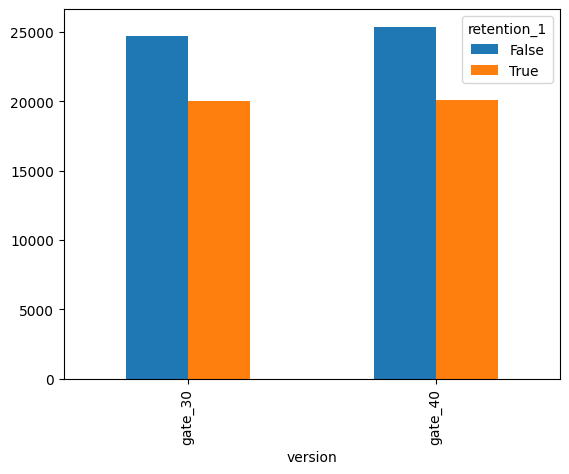

In [5]:
pd.crosstab(cookie_cats.version, cookie_cats.retention_1).plot(kind='bar');

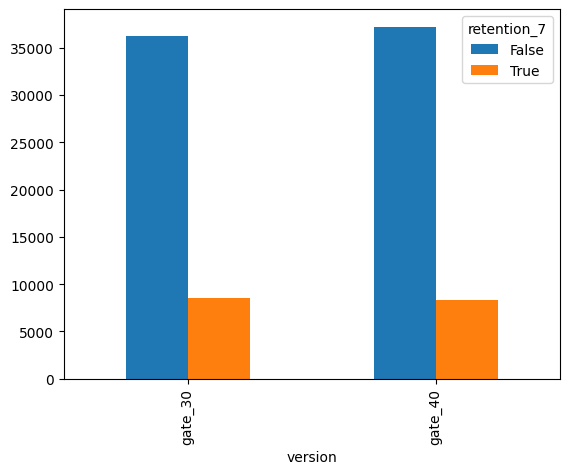

In [6]:
pd.crosstab(cookie_cats.version, cookie_cats.retention_7).plot(kind='bar');

In [7]:
cookie_cats.groupby('version').mean()[['retention_1', 'retention_7']]*100

,retention_1,retention_7
version,,
gate_30,44.818792,19.020134
gate_40,44.228275,18.200004


In [8]:
# transformacion
gate_30_retention_1 = cookie_cats[(cookie_cats.version == 'gate_30')][['userid','version','retention_1']]
gate_30_retention_7 = cookie_cats[(cookie_cats.version == 'gate_30')][['userid','version','retention_7']]


gate_40_retention_1 = cookie_cats[(cookie_cats.version == 'gate_40')][['userid','version','retention_1']]
gate_40_retention_7 = cookie_cats[(cookie_cats.version == 'gate_40')][['userid','version','retention_7']]

len(gate_30_retention_1), len(gate_40_retention_1), len(gate_30_retention_7), len(gate_40_retention_7)

(44700, 45489, 44700, 45489)

In [9]:
# muestreo
#muestreo_retencion_1:

control = gate_30_retention_1.sample(n=42000, random_state=22)

tratamiento = gate_40_retention_1.sample(n=42000, random_state=22)

ab_test_ret_1 = pd.concat([control, tratamiento], axis=0)

ab_test_ret_1.reset_index(drop=True, inplace=True)


#muestreo_retención_2:

control = gate_30_retention_7.sample(n=42000, random_state=22)

tratamiento = gate_40_retention_7.sample(n=42000, random_state=22)

ab_test_ret_7 = pd.concat([control, tratamiento], axis=0)

ab_test_ret_7.reset_index(drop=True, inplace=True)




In [10]:
ab_test_ret_1

,userid,version,retention_1
0,7540471,gate_30,True
1,3589138,gate_30,True
2,3177668,gate_30,True
3,2133884,gate_30,False
4,492763,gate_30,True
...,...,...,...
83995,483544,gate_40,False
83996,1775700,gate_40,True
83997,9383315,gate_40,True
83998,7487312,gate_40,False


In [11]:
#%pip install Jinja2

In [12]:
tasas_ret_1 = ab_test_ret_1.groupby('version')['retention_1']

tasas_ret_1 = tasas_ret_1.agg([np.mean,
                               lambda x: np.std(x, ddof=0),
                               lambda x: sem(x, ddof=0)
                               ])


tasas_ret_1.columns = ['retention_rate', 'std', 'sem']

tasas_ret_1.style.format('{:.3f}')

/var/folders/_x/p36xd5b939j8l74ph2prsbv80000gn/T/ipykernel_8106/1867343615.py:3: FutureWarning: The provided callable <function mean at 0x110db7560> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  tasas_ret_1 = tasas_ret_1.agg([np.mean,


,retention_rate,std,sem
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.444,0.497,0.002


In [13]:
tasas_ret_7 = ab_test_ret_7.groupby('version')['retention_7']

tasas_ret_7 = tasas_ret_7.agg([np.mean,
                               lambda x: np.std(x, ddof=0),
                               lambda x: sem(x, ddof=0)
                               ])


tasas_ret_7.columns = ['retention_rate', 'std', 'sem']

tasas_ret_7.style.format('{:.3f}')

/var/folders/_x/p36xd5b939j8l74ph2prsbv80000gn/T/ipykernel_8106/2426084786.py:3: FutureWarning: The provided callable <function mean at 0x110db7560> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  tasas_ret_7 = tasas_ret_7.agg([np.mean,


,retention_rate,std,sem
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


In [18]:
# testeo para retention_1
control_res = ab_test_ret_1[ab_test_ret_1.version=='gate_30']['retention_1']    #selection control (gate_30)

trat_res = ab_test_ret_1[ab_test_ret_1.version=='gate_40']['retention_1']       #selection tratamiento (gate_40)

sum(control_res), sum(trat_res)

download = [control_res.shape[0], trat_res.shape[0]]  # people with the app

ret_1 = [sum(control_res), sum(trat_res)]     # people that plays after the first day



z_score, p_value = proportions_ztest(ret_1, nobs=download)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(ret_1, 
                                                                nobs=download,
                                                                alpha=0.05)


In [19]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 1.31
p-valor: 0.190
intervalo conf 95% para grupo control: [0.443, 0.453]
intervalo conf 95% para grupo tratamiento: [0.439, 0.448]


In [21]:
# testeo para retention_7

control_res_7 = ab_test_ret_7[ab_test_ret_7.version=='gate_30']['retention_7']    #selection control (gate_30)

trat_res_7 = ab_test_ret_7[ab_test_ret_7.version=='gate_40']['retention_7']       #selection tratamiento (gate_40)

sum(control_res_7), sum(trat_res)

download_7 = [control_res_7.shape[0], trat_res_7.shape[0]]  # people with the app

ret_7 = [sum(control_res_7), sum(trat_res_7)]     # people that plays after the first day



z_score, p_value = proportions_ztest(ret_7, nobs=download_7)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(ret_7, 
                                                                nobs=download_7,
                                                                alpha=0.05)


In [22]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 2.87
p-valor: 0.004
intervalo conf 95% para grupo control: [0.186, 0.194]
intervalo conf 95% para grupo tratamiento: [0.179, 0.186]


In [17]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.